## Key Takeaways

### For NNs using Images
- Convolutions are helpful
- SGD isn't as good as newer optimizers like Adam and NesterovAdam - https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f
- normalization is helpful (both of the features and the output) and helps prevent divergence
- batch normalization works well after the activation https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md
- need to go deeper as validation loss is brought in line with training loss


### Generally
- Never trust the data blindly


#### Link to models
https://drive.google.com/drive/folders/1IcfVLCy_btNzYmqzvKzyVPFQQkKrYVvZ?usp=sharing

## Setup

### Imports

In [1]:
%matplotlib inline
from pandas.io.parsers import read_csv
from sklearn.model_selection import train_test_split

import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Input
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Nadam, Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping, Callback, History
from keras.applications.inception_v3  import InceptionV3
from keras.applications.vgg16 import VGG16

from tensorflow.python.client import device_lib

from augmentdata.CustImageDataGenerator import CustImageDataGenerator,CustNumpyArrayIterator

print(device_lib.list_local_devices()) # confirm using GPU

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6582281885003955759
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 18001392733852251792
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9096885988078670710
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11286970368
locality {
  bus_id: 1
}
incarnation: 14264138499565844030
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


### Constants

In [2]:
TRAIN_DATA = '/data/data/training.csv'                # train dataset downloaded from Kaggle
TEST_DATA = '/data/data/test.csv'                     # test dataset downloaded from Kaggle
IMAGE_ROWS = 96
IMAGE_COLS = 96
INPUT_SHAPE = (IMAGE_ROWS, IMAGE_COLS, 1)
RETRAIN = False                                    # bool to load and use existing saved models
VERBOSE_TRAIN = False                              # bool to show/hide progress while training a model
NUM_KEYPOINTS = 30                                 # maximum no. of facial keypoints for any image


## EDA on train dataset

We begin by examining the train dataset of images (training.csv file), which is organised as (x,y) coodinates of each of the 15 facial features for a total of 30 keypoints. The 31st column contains 96x96 image pixel array data coded as raw grayscale values from 0 to 255. There are a total of about 7000 images in the train dataset. 

**Summary**: 
*For the EDA, the first pass was done over the whole dataset. From this, roughly 320 images were identified that had missing keypoints or peculiarities, needing further evaluation. In this second pass, we decided to prune the input train dataset to the models, by picking out images that were misfits, and would likely end up confusing the model, rather than helping it. This analysis and some interesting images we came across are illustrated below.*


In [3]:
# Setting up the data for EDA

df_train = pd.read_csv(TRAIN_DATA)
Y = np.array(df_train[df_train.columns.difference(['Image'])])
X = df_train['Image']
labels = list(df_train.columns.difference(['Image']))

img_vec_len = IMAGE_ROWS*IMAGE_COLS                             # images pixel grid size

imgArray = np.zeros((X.shape[0], img_vec_len), dtype=int)       # temporary array to save each image as numpy array

idx=0
for i in X.keys(): 
    imgArray[idx] = np.fromstring(X[i], dtype=int, sep=' ')
    idx += 1
X = np.reshape( imgArray, (X.shape[0], IMAGE_ROWS, IMAGE_COLS, 1) )
print("Total images in train dataset: ", X.shape[0])

Total images in train dataset:  7049


In [4]:
# Function to subplot a group of images, and label the ones with missing keypoints distinctly

def plot_images(images, points, type='actual', subplotting=False, gridRows=0, gridCols=0, 
                imageIndices=1, subtitles=True, title=None, labelsList=[] ):
    
    plt.figure(figsize=(4*gridCols, 4*gridCols))    
    img_nums = images.shape[0]
    points_nums = points.shape[0]
    
    if ( ( img_nums != points_nums) | ( img_nums != imageIndices.shape[0] ) ):
        raise ValueError("Mismatch in number of images and keypoints' rows passed to plot_images().")
    
    
    for thisImg in range(0, gridRows*gridCols ):
        
        if subplotting:
            plt.subplot(gridRows, gridCols, thisImg + 1)
            noKeypNums  = np.isnan(points[thisImg]).sum()
            
            if subtitles:
                if( noKeypNums == 0 ):                                                            # no missing keypoints (group1)
                    plt.title("#: " + str(imageIndices[thisImg]) + 
                              ",  Points: " + str(NUM_KEYPOINTS - noKeypNums), color='k')         # title in black
                
                elif( ( noKeypNums > 0) & (noKeypNums < 22 ) ):                                   # (1,21) missing keypoints
                    plt.title("#: " + str(imageIndices[thisImg]) + 
                              ",  Points: " + str(NUM_KEYPOINTS - noKeypNums), color='m')         # title in magenta
                
                elif( ( noKeypNums == 22 ) ):                                                     # 22 missing keypoints (group2)
                    plt.title("#: " + str(imageIndices[thisImg]) + 
                              ",  Points: " + str(NUM_KEYPOINTS - noKeypNums), color='b')         # title in blue
                
                else:                                                                             # > 22 missing keypoints
                    plt.title("#: " + str(imageIndices[thisImg]) + 
                              ",  Points: " + str(NUM_KEYPOINTS - noKeypNums), color='r')         # title in red
        
        plt.imshow(np.reshape(images[thisImg,:],(96,96)), cmap = 'gray')

        x = 0
        for idx in range(0, points[thisImg].shape[0]):
            label = labelsList[idx]
            if label[-1]=='x':
                x = points[thisImg, idx]
            else:
                if label in ['left_eye_center_y',
                             'left_eye_inner_corner_y', 
                             'left_eye_outer_corner_y', 
                             'left_eyebrow_inner_end_y', 
                             'left_eyebrow_outer_end_y',
                             'mouth_left_corner_y'
                            ]:
                    if(type=='actual'):
                        plt.plot(x, points[thisImg, idx], 'c<')
                    else:
                        plt.plot(x, points[thisImg, idx], 'c*')
                        
                elif label in ['right_eye_center_y',
                             'right_eye_inner_corner_y', 
                             'right_eye_outer_corner_y', 
                             'right_eyebrow_inner_end_y', 
                             'right_eyebrow_outer_end_y',
                              'mouth_right_corner_y']:
                    if(type=='actual'):
                        plt.plot(x, points[thisImg, idx], 'r>')
                    else:
                        plt.plot(x, points[thisImg, idx], 'r*')
                
                else:
                    if(type=='actual'):
                        plt.plot(x, points[thisImg, idx], 'mo')
                    else:
                        plt.plot(x, points[thisImg, idx], 'm*')
                    
        plt.axis('off')
    
    if (title != None):
        plt.suptitle(title)
    plt.show()

In [5]:
# Function to plot an array of image indices

idx_max = df_train.shape[0]                      # all images
grid_cols = 4                                    # grid columns size for a subplot of images
grid_rows = 4                                    # grid rows size for images subplot
subImgNum = grid_cols * grid_rows

def plot_img_group( thisGroup, dataset='train', denorm=False, thisLabels=labels, thisSubTitle=True, thisTitle=None ):

    if(dataset == 'train'):
        thisX = X
        thisY = Y
    elif(dataset == 'group1'):
        thisX = X1
        thisY = Y1
    elif(dataset == 'group2'):
        thisX = X2
        thisY = Y2     
    
    thisSubsetX = np.zeros( (subImgNum, IMAGE_ROWS, IMAGE_COLS, 1), dtype=float)
    thisSubsetY = np.zeros( (subImgNum, thisY.shape[1]), dtype=float)
    img_indices = np.zeros( (subImgNum, 1), dtype=int)

    img_sub = 0                                  # local iterator for images in subplot
    flushed = False
    for img in thisGroup:
        
        if( ( (img_sub + 1 )  % subImgNum ) != 0 ):
            thisSubsetX[img_sub,:] = thisX[img-1,:]
            if denorm:
                thisSubsetY[img_sub,:] = 48*thisY[img-1,:] + 48
            else:
                thisSubsetY[img_sub,:] = thisY[img-1,:]
            img_indices[img_sub] = img
            img_sub += 1
            flushed = False
            
        else:
            thisSubsetX[img_sub,:] = thisX[img-1,:]
            if denorm:
                thisSubsetY[img_sub,:] = 48*thisY[img-1,:] + 48
            else:
                thisSubsetY[img_sub,:] = thisY[img-1,:]
            img_indices[img_sub] = img
            
            # plot when all images for the subplot are accumulated
            plot_images(images=thisSubsetX, points=thisSubsetY, subplotting=True, 
                        gridRows=grid_rows, gridCols=grid_cols, imageIndices=img_indices, 
                        subtitles=thisSubTitle, title=thisTitle, labelsList=thisLabels )
            
            # reset subplot indexing pointer and subplot image/keypoints buckets
            img_sub = 0
            flushed = True
            thisSubsetX = np.zeros( (subImgNum, IMAGE_ROWS, IMAGE_COLS, 1), dtype=int)
            thisSubsetY = np.zeros( (subImgNum, Y.shape[1]), dtype=float)
    
    if not flushed:                              # for images leftover from partial subplot grid

        thisGridRows = ( (img_sub - 1) // grid_rows ) + 1
        if( thisGridRows > 1 ):
            thisGridCols = grid_cols
        else:
            thisGridCols = img_sub

        plot_images(images=thisSubsetX, points=thisSubsetY, subplotting=True, 
                    gridRows=thisGridRows, gridCols=thisGridCols, imageIndices=img_indices, 
                    subtitles=thisSubTitle, title=thisTitle, labelsList=thisLabels )


The images in the train dataset seem to be broadly split into two groups. The first group starts from the beginning of the dataset and (index 1, or row 1 in .csv) and continues till index 2284. Beyond that, the images have a maximum of 8 keypoints.

Below is a sample of images around this boundary - images with 30 keypoints or less and those with 8 keypoints or less. Also, there are some images with missing keypoints, with their titles highlighted in magenta or red colors.

In [10]:
# Final indices of images to be dropped from the dataset

IDX_BAD_IMAGES = np.array( [1621, 1862, 1748, 1878, 1927, 2200, 2431, 2584, 2647, 
                            2671, 2765, 4198, 1627, 1628, 1637, 1957, 4477, 1820, 
                            2064, 2089, 2091, 2109, 2195, 4264, 4491, 6490, 6493, 
                            6494, 1655, 2096, 2454, 3206, 3287, 5628, 5653, 6754, 
                            6755, 2321, 2322, 2414, 2428, 2462, 2574, 2584, 2663, 
                            2691, 2694, 2830, 2910, 2916, 3126, 3176, 3291, 3299, 
                            3361, 4061, 4483, 4484, 4494, 4766, 4809, 4837, 4880, 
                            4905, 5068, 5362, 5566, 5868, 6535, 6538, 6588, 6605, 
                            6659, 6724, 6733, 6753, 6758, 6766, 6907 ] )
#plot_img_group( IDX_BAD_IMAGES )

### Preparing the training data for models

In [11]:
# Function to clean up the train dataset, normalize it, drop bad images & labels, 
# and finally split the dataset into 2, for group1 and group2 modelling.

def loaderV2(test=False, seed=None, keeplabels=None):
    
    if seed:
        np.random.seed(seed)
    fileloc = TEST_DATA if test else TRAIN_DATA
    
    df = read_csv(fileloc)
    
    df['Image'] = df['Image'].apply(lambda x: np.fromstring(x, sep=' '))
    
    if keeplabels:
        df = df[list(keeplabels) + ['Image']]
        
    X = np.vstack(df['Image'])
    
    if not test:                                                  # process train dataset
        Y = df[df.columns.difference(['Image'])].values
        Y = Y.astype(np.float32)
        
        # remove rows having bad images or labels
        X = np.delete( X, (IDX_BAD_IMAGES - 1), axis=0 )
        Y = np.delete( Y, (IDX_BAD_IMAGES - 1), axis=0 )
        
        # normalize - by pixel across the whole dataset subtract mean and divide by stdev
        X = X - np.tile(np.mean(X,axis=0),(X.shape[0],1))
        X = X / np.tile(np.std(X,axis=0),(X.shape[0],1))
        X = X.astype(np.float32)
    
        Y = (Y - 48) / 48                     # this helps, but tanh on output doesnt
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, Y = X[shuffle], Y[shuffle]
    
        X = X.reshape(-1, 96, 96, 1)
        
        # split X and Y into dataset for model1 (more than 8 keypoints) and model2 (less than 8 keypoints)
        X_model1 = np.zeros( (X.shape[0], 96,96,1), dtype=np.float32)
        X_model2 = np.zeros( (X.shape[0], 96,96,1), dtype=np.float32)
        Y_model1 = np.zeros( Y.shape, dtype=float)
        Y_model2 = np.zeros( Y.shape, dtype=float)
        tempIdx1 = 0
        tempIdx2 = 0
        
        for thisIdx in range(0, Y.shape[0]):
            numKeyps  = NUM_KEYPOINTS - np.isnan(Y[thisIdx]).sum()
            
            if( ( numKeyps > 8 ) ):
                X_model1[tempIdx1] = X[thisIdx,:,:]
                Y_model1[tempIdx1] = Y[thisIdx,:]
                tempIdx1 = tempIdx1 + 1
            else:
                X_model2[tempIdx2] = X[thisIdx,:,:]
                Y_model2[tempIdx2] = Y[thisIdx,:]
                tempIdx2 = tempIdx2 + 1
    
        # remove empty rows
        drop_idx1 = []
        drop_idx2 = []
        
        for idx in range(0, X.shape[0]):
            if( (np.all(Y_model1[idx] == 0)) | (np.isnan(Y_model1[idx]).sum() != 0) ):
                drop_idx1.append(idx)
            if( (np.all(Y_model2[idx] == 0)) | (np.isnan(Y_model2[idx]).sum() != 22) ):
                drop_idx2.append(idx)
        
        X_model1 = np.delete( X_model1, np.array(drop_idx1), axis=0 )
        Y_model1 = np.delete( Y_model1, np.array(drop_idx1), axis=0 )
        X_model2 = np.delete( X_model2, np.array(drop_idx2), axis=0 )
        Y_model2 = np.delete( Y_model2, np.array(drop_idx2), axis=0 )            
        
        # remove empty columns, setup lists of labels
        labels = df.columns.difference(['Image'])
        labels1 = labels
        labels2 = []
        drop_idx3 = []
        for idx in range(0, Y.shape[1]):
            if( (np.all(Y_model2[:,idx] == 0)) | (np.isnan(Y_model2[:,idx]).sum() != 0) ):
                drop_idx3.append(idx)
            else:
                labels2.append(labels[idx])
        Y_model2 = np.delete( Y_model2, np.array(drop_idx3), axis=1 ) 
        
        # return the original dataset and the group splits
        return X_model1, Y_model1, labels1, X_model2, Y_model2, labels2, X, Y, labels
    
    else:                                             # for test dataset
        Y = None
        
        # normalize - by pixel across the whole dataset subtract mean and divide by stdev
        X = X - np.tile(np.mean(X,axis=0),(X.shape[0],1))
        X = X / np.tile(np.std(X,axis=0),(X.shape[0],1))
        X = X.reshape(-1, 96, 96, 1)
        labels = df.columns.difference(['Image'])
        
        return X, Y, labels
    

In [29]:
X1, Y1, labels1,   X2, Y2, labels2,   X, Y, labels = loaderV2(seed=42)

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1,
                                                        test_size=0.2,
                                                        random_state=42)

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2,
                                                        test_size=0.2,
                                                        random_state=42)

data1 = [X1_train, X1_test, Y1_train, Y1_test]
data2 = [X2_train, X2_test, Y2_train, Y2_test]


In [30]:
print("Group1 data Y1 shape: ", Y1.shape, ", X1 shape: ", X1.shape)
print("Group2 data Y2 shape: ", Y2.shape, ", X2 shape: ", X2.shape)


Group1 data Y1 shape:  (2137, 30) , X1 shape:  (2137, 96, 96, 1)
Group2 data Y2 shape:  (4697, 8) , X2 shape:  (4697, 96, 96, 1)


### Plot some sample images

### Model Fitting Function

In [32]:
def fit_model(model, data, modelname,
              generator=None,retrain=RETRAIN,
              epochs=10000, patience=1000, optimizer='nadam'):
    if retrain or not os.path.exists('/data/saved-models/' + modelname + '.h5'):
        X_train = data[0]
        y_train = data[2]
        if len(data) == 4:
            valid_dat = (data[1], data[3])
        else:
            valid_dat = None

        model.compile(loss='mse', optimizer=optimizer)
        
        if valid_dat:
            earlystop = EarlyStopping(monitor='val_loss',
                                     patience=patience,
                                     verbose=1,
                                     mode="auto")
            callbacks = [earlystop]
        else:
            callbacks = None
        
        if generator:
            history = model.fit_generator(generator,
                        epochs=epochs,
                        steps_per_epoch=data[0].shape[0]//32,
                        callbacks=callbacks,
                        validation_data=valid_dat
             )
        else:
            history = model.fit(X_train, y_train,
                                epochs=epochs,
                                batch_size=32,
                                callbacks=callbacks,
                                validation_data=valid_dat,
                                verbose=VERBOSE_TRAIN
                     )
        model.save('/data/saved-models/'+ modelname + '.h5')
        with open('/data/saved-models/histories/'+modelname+'_hist',
                  'wb') as file_pi:
            pickle.dump(history.history, file_pi)
        history = history.history
    else:
        model = load_model('/data/saved-models/'+modelname+'.h5')
        history = pickle.load(open( "/data/saved-models/histories/" + modelname + '_hist',
                                   "rb" ))
        
    return history, model

### Helper function to plot the loss

In [55]:
def plot_loss(hists, names):
    colordict = {
        0 : 'b',
        1 : 'g',
        2 : 'r',
        3 : 'c',
        4 : 'm'
    }
    
    for i, hist in enumerate(hists):
        plt.plot([np.sqrt(x) * 48 for x in hist['loss']],
                 color=colordict[i],
                 label="train " + names[i])
        plt.plot([np.sqrt(x) * 48 for x in hist['val_loss']],
                 color=colordict[i],
                 linestyle=':',
                 label="valid " + names[i])
        plt.grid()
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("RMSE")
        plt.yscale("log")
    plt.show()

<h3>CNN_added layers model: </h3>

In [35]:
datagen = CustImageDataGenerator(
    rotation_range=5. #degrees
     ,horizontal_flip=True
     ,width_shift_range=.05 # percent of image width
     ,height_shift_range=.05 # percent of image height
    ).flow(X1_train,Y1_train,whichlabels=list(labels1), batch_size=32)

In [42]:
g1_model3_new = Sequential()
g1_model3_new.add(Conv2D(32,
                 (6, 6),
                 activation='relu',
                input_shape=INPUT_SHAPE))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3_new.add(Conv2D(filters=64,
                 kernel_size=(5, 5),
                 activation='relu'))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(MaxPooling2D(pool_size=(2, 2)))

g1_model3_new.add(Conv2D(filters=256,
                 kernel_size=(4, 4),
                 activation='relu'))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3_new.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 activation='relu'))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(MaxPooling2D(pool_size=(2, 2)))
g1_model3_new.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(MaxPooling2D(pool_size=(2, 2)))

g1_model3_new.add(Flatten())
g1_model3_new.add(Dense(500, activation = "relu"))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(Dense(500, activation = "relu"))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(Dropout(.3))
g1_model3_new.add(Dense(30))
print(g1_model3_new.summary())
g1_CNN_aug_addedLayers_hist, g1_model3_new = fit_model(g1_model3_new, data1,
                                'g1_CNN_aug_addedLayers',datagen,
                                patience=1000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 91, 91, 32)        1184      
_________________________________________________________________
batch_normalization_22 (Batc (None, 91, 91, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 41, 41, 64)        51264     
_________________________________________________________________
batch_normalization_23 (Batc (None, 41, 41, 64)        256       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 17, 17, 256)       262400    
__________

<H3> Using VGG: </H3>

In [20]:
# force grayscale into 3 channels
X1_train_3chan = np.tile(X1_train,(1,1,1,3))
X1_test_3chan = np.tile(X1_test,(1,1,1,3))
data_vgg=[X1_train_3chan, X1_test_3chan, Y1_train, Y1_test]

# new 3 channel data generator
datagen_vgg = CustImageDataGenerator(
    rotation_range=5. #degrees
     ,horizontal_flip=True
     ,width_shift_range=.05 # percent of image width
     ,height_shift_range=.05 # percent of image height
    ).flow(X1_train_3chan,Y1_train,whichlabels=list(labels1), batch_size=32)



In [21]:
# create the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# add the keypoints detection layer
predictions = Dense(30)(x)

# this is the model we will train
model_vgg = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

print(model_vgg.summary())
model_vgg_hist, model_vgg = fit_model(model_vgg, data_vgg,'g1_vgg', datagen_vgg, patience=1000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [23]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model_vgg.layers[:249]:
    layer.trainable = False
for layer in model_vgg.layers[249:]:
    layer.trainable = True

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model_vgg_hist2, model_vgg2 = fit_model(model_vgg, data_vgg,'g1_vgg2',datagen_vgg, patience=1000)

# train all layers!
for layer in model_vgg.layers:
    layer.trainable = True

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model_vgg_hist3, model_vgg3 = fit_model(model_vgg, data_vgg,'g1_vgg3',datagen_vgg, patience=1000)

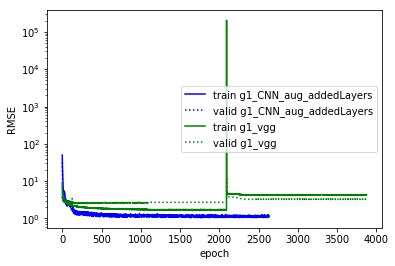

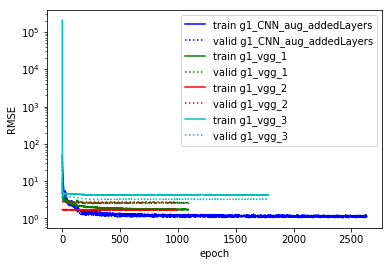

In [48]:
# compare loss
model_vgg_hist_all = {}
model_vgg_hist_all['loss'] = (model_vgg_hist['loss'] + model_vgg_hist2['loss'] + model_vgg_hist3['loss'])
model_vgg_hist_all['val_loss'] = (model_vgg_hist['val_loss'] + model_vgg_hist2['val_loss'] + model_vgg_hist3['val_loss'])

plot_loss([g1_CNN_aug_addedLayers_hist, model_vgg_hist_all],
           ['g1_CNN_aug_addedLayers','g1_vgg'])


plot_loss([g1_CNN_aug_addedLayers_hist, model_vgg_hist, model_vgg_hist2, model_vgg_hist3],
           ['g1_CNN_aug_addedLayers','g1_vgg_1','g1_vgg_2','g1_vgg_3'])

### Using a model from the zoo
We try to train the InceptionV3 model to see if it does a better job. This model was chosen because it has good evaluation results, but has fewer parameters than some of the other competition-winning models.

#### Setup
In order to use InceptionV3, we need a 3 channel input. To fit this, we can just repeat the grayscale value for each of the 3 channels. We also have to change the data generator to create 3 channel images.

In [49]:
# force grayscale into 3 channels
X1_train_3chan = np.tile(X1_train,(1,1,1,3))
X1_test_3chan = np.tile(X1_test,(1,1,1,3))
data1_inceptionV3=[X1_train_3chan, X1_test_3chan, Y1_train, Y1_test]

# new 3 channel data generator
datagen_inceptionV3 = CustImageDataGenerator(
    rotation_range=5. #degrees
     ,horizontal_flip=True
     ,width_shift_range=.05 # percent of image width
     ,height_shift_range=.05 # percent of image height
    ).flow(X1_train_3chan,Y1_train,whichlabels=list(labels1), batch_size=32)


#### Train the model
We train the model in 3 steps.
1. Create the base model and add a global average pooling layer, a dense layer, and an output layer. Then train the 3 added layers.
1. Train layers further up from the end (layer 250 through to the output layer).
1. Train all the layers.

In [50]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# add the keypoints detection layer
predictions = Dense(30)(x)

# this is the model we will train
model_inceptionV3 = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

print(model_inceptionV3.summary())
model_inceptionV3_hist, model_inceptionV3 = fit_model(model_inceptionV3, data1_inceptionV3,
                                                      'g1_zoo', datagen_inceptionV3,
                                                      patience=1000)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, None, None, 3 96          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_29[0][0]     
__________________________________________________________________________________________________
conv2d_22 

In [51]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model_inceptionV3.layers[:249]:
    layer.trainable = False
for layer in model_inceptionV3.layers[249:]:
    layer.trainable = True

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model_inceptionV3_hist2, model_inceptionV3 = fit_model(model_inceptionV3, data1_inceptionV3,
                                'g1_zoo2',datagen_inceptionV3,
                                patience=1000)


In [52]:
# train all layers!
for layer in model_inceptionV3.layers:
    layer.trainable = True

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model_inceptionV3_hist3, model_inceptionV3 = fit_model(model_inceptionV3, data1_inceptionV3,
                                'g1_zoo3',datagen_inceptionV3,
                                patience=1000)

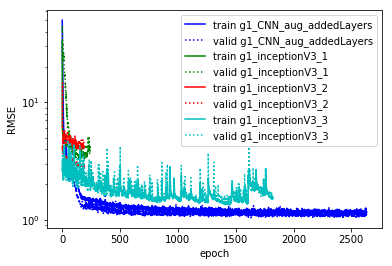

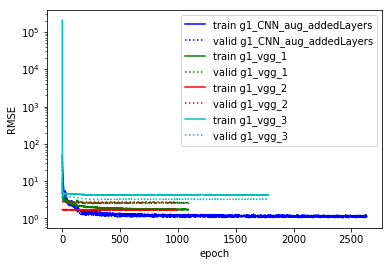

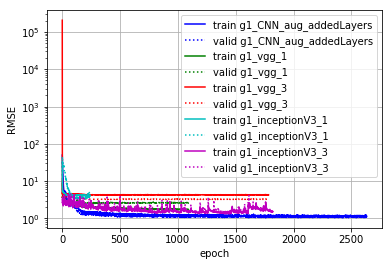

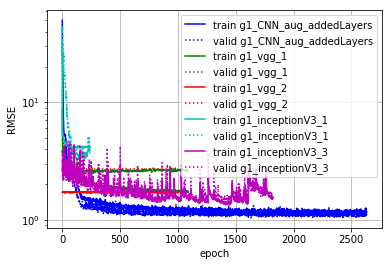

In [57]:
# compare loss
model_inceptionV3_hist_all = {}
model_inceptionV3_hist_all['loss'] = (model_inceptionV3_hist['loss'] +
                                      model_inceptionV3_hist2['loss'] +
                                      model_inceptionV3_hist3['loss']
                                      )
model_inceptionV3_hist_all['val_loss'] = (model_inceptionV3_hist['val_loss'] +
                                          model_inceptionV3_hist2['val_loss'] +
                                          model_inceptionV3_hist3['val_loss']
                                          )
plot_loss([g1_CNN_aug_addedLayers_hist, model_inceptionV3_hist, model_inceptionV3_hist2, model_inceptionV3_hist3],
           ['g1_CNN_aug_addedLayers','g1_inceptionV3_1','g1_inceptionV3_2','g1_inceptionV3_3'])
plot_loss([g1_CNN_aug_addedLayers_hist, model_vgg_hist, model_vgg_hist2, model_vgg_hist3],
           ['g1_CNN_aug_addedLayers','g1_vgg_1','g1_vgg_2','g1_vgg_3'])
plot_loss([g1_CNN_aug_addedLayers_hist, model_vgg_hist, model_vgg_hist3, model_inceptionV3_hist, model_inceptionV3_hist3],
           ['g1_CNN_aug_addedLayers','g1_vgg_1','g1_vgg_3','g1_inceptionV3_1','g1_inceptionV3_3'])
plot_loss([g1_CNN_aug_addedLayers_hist, model_vgg_hist, model_vgg_hist2, model_inceptionV3_hist, model_inceptionV3_hist3],
           ['g1_CNN_aug_addedLayers','g1_vgg_1','g1_vgg_2','g1_inceptionV3_1','g1_inceptionV3_3'])

It appears InceptionV3 loses out to our first data-augmented model. This is likely because we just don't have enough training examples to get enough variance into the Inception model that its generalization functionality works. It does appear the validation and training loss go hand in hand for the InceptionV3 model.